# Classifying ALE SNPs with Bitome

## Setup

### Import Required Packages

In [1]:
from pathlib import Path
import pickle
import sys
import uuid

import kerastuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())

from bitome.core import Bitome

### Define Global Variables

In [2]:
DATA_PATH = Path('..', 'data', 'classification', 'snp')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
FIG_PATH = Path('..', 'figures', 'figure_4')

### Load Pre-Prepared Bitome Knowledgebase

In [3]:
bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

### Prepare Feature Matrix

We want to test sum and mean for combination of features across positions, and some different scalers to deal with non-normal distributions of features

In [4]:
# load the locus tags and SNP labels for training
locus_tag_label_lookup = pd.read_csv(Path(DATA_PATH, 'train.csv'), index_col=0, squeeze=True)
Y_ORIG = locus_tag_label_lookup.values

# extract the sub-matrix for each locus tag
GENE_SUB_MATRICES = []
for locus_tag in locus_tag_label_lookup.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    GENE_SUB_MATRICES.append(sub_matrix)
    
X_SUM_ORIG = np.array([np.asarray(sub_mat.toarray()).sum(axis=1) for sub_mat in GENE_SUB_MATRICES])
X_MEAN_ORIG = np.array([np.asarray(sub_mat.toarray()).mean(axis=1) for sub_mat in GENE_SUB_MATRICES])
print(f'{X_SUM_ORIG.shape}')

# we can define the y we will use now; this ASSUMES that the below helper function will always return 
# a down-sampled X matrix in the appropriate format
neg, pos = np.bincount(Y_ORIG)
y = np.append(np.zeros(neg), np.ones(neg))

(3349, 1634)


#### Helper Function: Prepare Downsampled Features and Labels with Provided Normalization

In [5]:
def downsample_X(flatten_strategy='sum', scaling='minmax'):
    
    # compute our original, imbalanced feature matrix
    if flatten_strategy == 'sum':
        X_imbalanced = X_SUM_ORIG
    elif flatten_strategy == 'mean':
        X_imbalanced = X_MEAN_ORIG
        
    # extract the positive and negative portions of the imbalanced matrix so we can resample the majority class
    neg, pos = np.bincount(Y_ORIG)
    
    X_neg = X_imbalanced[Y_ORIG == 0, :]
    X_pos = X_imbalanced[Y_ORIG == 1, :]
    X_pos_downsample = resample(X_pos, replace=True, n_samples=neg)
    X_downsampled = np.vstack((X_neg, X_pos_downsample))
    
    if scaling == 'minmax':
        X_scaled = MinMaxScaler().fit_transform(X_downsampled)
    elif scaling == 'robust':
        X_scaled = RobustScaler().fit_transform(X_downsampled)
    
    return X_scaled

### Define Helper Functions

#### Run Neural Network

In [6]:
def run_nn_model(model_params, X_train, y_train, X_val, y_val, return_model=False):

    # instantiate the Sequential model
    model = keras.Sequential()
    
    # add the hidden layers; use the He initialization method learned from NN course 
    for layer_size, dropout_rate in zip(model_params['hidden_layer_sizes'], model_params['dropout_rates']):
        model.add(layers.Dense(
            layer_size,
            activation='relu',
            kernel_initializer=keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.l2(model_params['l2'])
        ))
        model.add(layers.Dropout(dropout_rate))
    
    # add the output layer, using the initial bias computed above
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # define the metrics we'd like to use
    metrics = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]
    
    # compile the model using typical optimizer and loss function
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        verbose=1,
        patience=10,
        mode='max',
        restore_best_weights=True
    )
    
    # now that we've done some computation in easier NumPy format, convert the matrices to tensors
    X_train, y_train, X_val, y_val = [tf.convert_to_tensor(mat) for mat in [X_train, y_train, X_val, y_val]]
    
    # fit the model to the training data
    model_history = model.fit(
        X_train,
        y_train,
        epochs=100,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    result_dict = {}
    for metric in model.metrics_names:
        result_dict[f'train_{metric}'] = model_history.history[metric][-1]
        result_dict[f'test_{metric}'] = model_history.history[f'val_{metric}'][-1]
    
    if return_model:
        return model
    else:
        return result_dict

#### Run scikit-learn Models

In [7]:
def run_models(models_dict, X_dict, y, cv=5, file_path=None):
    """
    Runs the provided models in the models_dict with the given X matrices and targets
    
    Models_dict and X_dict have key/value pairs in the following form -> model_name: model, X_name: X_matrix
    Uses sklearn's cross_validate under the hood
    """
    
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)

    # instantiate an empty dataframe to store our results
    full_cv_result_df = pd.DataFrame()

    for model_name, model in models_dict.items():
        print(f'{model_name}')

        for X_name, X in X_dict.items():
            print(f'{model_name}: {X_name}')

            # fit the provided model to the training set; use Keras specifically for the NN
            # 'model' for the nn is actually a dict of model parameters
            if type(model) == dict:
                for train_index, val_index in StratifiedKFold(n_splits=cv, shuffle=True).split(X, y):
                    # use the StratifiedKFold-provided indices to split the training set
                    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
                    result_row_dict = run_nn_model(model, X_train, y_train, X_val, y_val)
                    result_row_dict['model'] = model_name
                    result_row_dict['x_matrix'] = X_name
                    full_cv_result_df = full_cv_result_df.append(result_row_dict, ignore_index=True)
            else:
                # define the desired scoring metrics
                def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
                def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
                def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
                def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
                scoring = {
                    'tp': make_scorer(tp),
                    'tn': make_scorer(tn),
                    'fp': make_scorer(fp),
                    'fn': make_scorer(fn),
                    'auc': 'roc_auc',
                    'accuracy': 'accuracy'
                }

                # use stratified cross validation to assess model performance
                cv_result_df = pd.DataFrame(cross_validate(
                    model,
                    X,
                    y,
                    cv=cv,
                    scoring=scoring,
                    n_jobs=4,
                    return_train_score=True
                ))
                cv_result_df['model'] = [model_name] * cv
                cv_result_df['x_matrix'] = [X_name] * cv

                full_cv_result_df = full_cv_result_df.append(cv_result_df, ignore_index=True)

    # add a column that conveniently calculates the overfit difference (train - test score)
    full_cv_result_df['overfit'] = full_cv_result_df['train_auc'] - full_cv_result_df['test_auc']

    # save the result df so we don't have to run this initial screen again later
    if file_path is not None:
        full_cv_result_df.to_csv(file_path)

    return full_cv_result_df

#### Plot Model Performance

In [47]:
def plot_performance(result_df, confusion_matrix=False, overfit=False):
    
    if len(result_df['x_matrix'].unique()) > 1:
        hue = 'x_matrix'
    else:
        hue = None

    _, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x='model', y='test_accuracy', data=result_df, hue=hue, dodge=True, ax=ax)
    ax.set_xticklabels(['AdaBoost', 'LR', 'NN', 'RF', 'SVM', 'XGBoost'])
    ax.tick_params(axis='both', labelsize=14)
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Accuracy', fontsize=15)

    if overfit:
        _, ax = plt.subplots(figsize=(10, 5))
        sns.swarmplot(x='model', y='overfit', data=result_df, hue=hue, dodge=True, ax=ax)
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='both', labelsize=14)
        if hue is not None:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
        ax.set_xlabel('')
        ax.set_ylabel('Overfit', fontsize=15)
    
    if confusion_matrix:
        
        unique_models = result_df['model'].unique()
        num_models = len(unique_models)
        if num_models == 1:
            subplot_dims, figsize = (1, 1), (4, 3)
        elif num_models == 2:
            subplot_dims, figsize = (1, 2), (8, 3)
        elif 3 <= num_models <= 4:
            subplot_dims, figsize = (2, 2), (8, 6)
        elif 5 <= num_models <= 6:
            subplot_dims, figsize = (2, 3), (12, 6)
        elif 7 <= num_models <= 8:
            subplot_dims, figsize = (2, 4), (12, 6)
        
        _, axs = plt.subplots(*subplot_dims, figsize=figsize)
        if num_models == 1:
            axs = [axs]
        else:
            axs = axs.flatten()

        for model_name, ax in zip(unique_models, axs):
            
            model_result_df = result_df[result_df['model'] == model_name]
            tn, fp, fn, tp = model_result_df[['test_tn', 'test_fp', 'test_fn', 'test_tp']].mean(axis=0)

            conf_mat = np.array([np.array([tn, fp]) / (tn + fp), np.array([fn, tp]) / (fn + tp)])

            sns.heatmap(
                conf_mat,
                cmap="PuBu",
                annot=True,
                annot_kws={'fontsize': 13},
                cbar=False,
                square=True,
                xticklabels=['No SNP', 'SNP'],
                yticklabels=['No SNP', 'SNP'],
                ax=ax
            )
            ax.tick_params(axis='both', labelsize=12)
            ax.tick_params(axis='y', rotation=0)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.set_title(model_name)
            ax.set_xlabel('Predicted Class', fontsize=12)
            ax.set_ylabel('True Class', fontsize=12)

        if len(axs) > num_models:
            axs[-1].set_visible(False)

        plt.tight_layout()

#### Run Models and Plot

In [9]:
def run_models_and_plot_performance(
        models_dict,
        X_dict,
        y,
        cv=5,
        file_path=None,
        confusion_matrix=False
    ):
    result_df = run_models(models_dict, X_dict, y, cv=5, file_path=file_path)
    plot_performance(result_df, confusion_matrix=confusion_matrix)
    return result_df

## Model Selection

### Define Models to Try

In [23]:
models_to_try = {
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga'
    ),
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'hidden_layer_sizes': [16],
        'dropout_rates': [0.5],
        'l2': 0
    },
    'Random Forest': RandomForestClassifier(
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False
    ),
    'XGBoost': XGBClassifier(
        n_jobs=4
    )
}

X_to_try = {f'downsample_{i}': downsample_X() for i in range(5)}

### Downsampling Evaluation

We want to check that different majority-class downsamples aren't significantly altering performance with the same model

Loaded cached result!


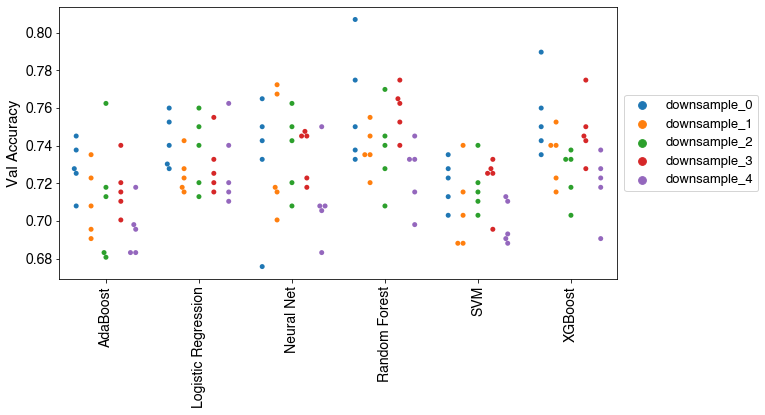

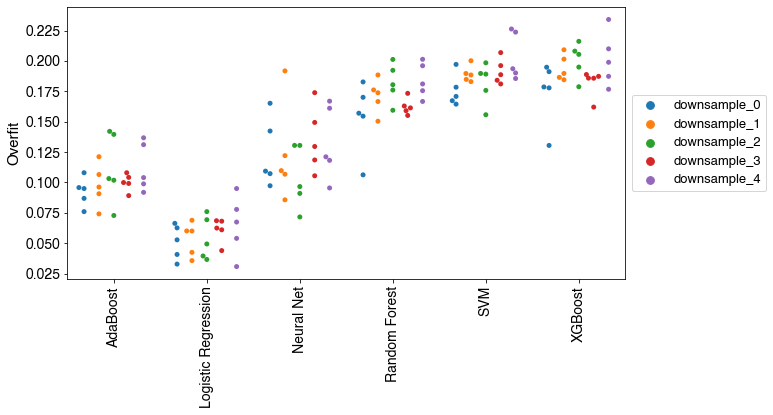

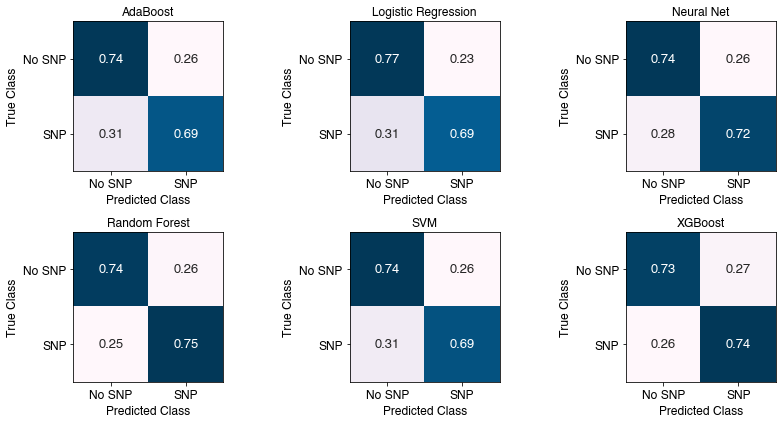

In [11]:
downsample_eval_df = run_models_and_plot_performance(
    models_to_try,
    X_to_try,
    y,
    file_path=Path(DATA_PATH, 'downsample_eval.csv'),
    confusion_matrix=True
)

So we get some amount of variance; moving forward, let's use 5 downsamples to assess performance to get a truer idea

### Feature Scaling

Test out different feature scalings to determine the best one for our models

In [24]:
models_to_try_scaling = models_to_try

X_to_try_scaling = {
    **{f'minmax_sum_{i}': downsample_X(flatten_strategy='sum', scaling='minmax') for i in range(5)},
    **{f'robust_sum_{i}': downsample_X(flatten_strategy='sum', scaling='robust') for i in range(5)},
    **{f'minmax_mean_{i}': downsample_X(flatten_strategy='mean', scaling='minmax') for i in range(5)},
    **{f'robust_mean_{i}': downsample_X(flatten_strategy='mean', scaling='robust') for i in range(5)},
}

In [22]:
scaling_path = Path(DATA_PATH, 'scaling_eval.csv')
scaling_result_df = run_models(models_to_try_scaling, X_to_try_scaling, y, file_path=scaling_path)
# let's change the x_matrix column to not have any downsample indices (just pool all the downsamples together)
# we only want to compare the scaling here

# un-comment if we ever stop loading from cache
# scaling_result_df['x_matrix'] = scaling_result_df['x_matrix'].apply(lambda name: name[:-2])
# scaling_result_df.to_csv(scaling_path)

plot_performance(scaling_result_df)

NameError: name 'models_to_try_scaling' is not defined

So we see a pretty clear advantage of using the minmax sum approach; let's stick with that version of the matrix

### Sequence Feature Screening

Let's see how well just the sequence predicts

In [25]:
X_to_try_seq = {
    **{f'bitome_{i}': downsample_X() for i in range(5)},
    **{f'seq_{i}': downsample_X()[:, :8] for i in range(5)},
    **{f'no_seq_{i}': downsample_X()[:, 8:] for i in range(5)},
    **{f'shuffled_{i}': np.random.permutation(downsample_X()) for i in range(5)},
}

models_to_try_seq = models_to_try

Loaded cached result!


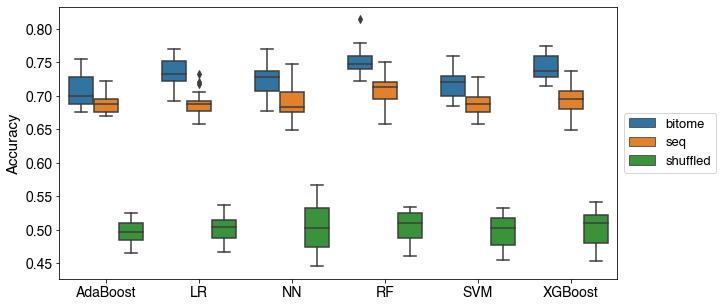

In [48]:
seq_path = Path(DATA_PATH, 'seq_feature_eval.csv')
seq_feature_result_df = run_models(models_to_try_seq, X_to_try_seq, y, file_path=seq_path)

# let's change the x_matrix column to not have any downsample indices (just pool all the downsamples together)
# we only want to compare the scaling here
# un-comment if we stop loading from cache
# seq_feature_result_df['x_matrix'] = seq_feature_result_df['x_matrix'].apply(lambda name: name[:-2])
# seq_feature_result_df.to_csv(seq_path)
seq_feature_result_df = seq_feature_result_df[seq_feature_result_df['x_matrix'] != 'no_seq']
plot_performance(seq_feature_result_df)
plt.savefig(Path(FIG_PATH, 'out_of_box_models.svg'))

So the bitome features are just edging out the sequence features alone; let's use those!

## Hyperparameter Optimization

### Prepare Single Feature Matrix

We want to be able to compare the different parameters equally and across models; we could try to get to the "true" performance by averaging across multiple downsamples as above, but I assert that we'll get the same results by just choosing a particular downsample and sticking with it (plus it will be 5x faster)

In [10]:
X_hyperopt = downsample_X()

### Define Helper Functions

#### Hyperoptimization

In [11]:
def hyperoptimize_nn(param_dict, X, y, n_iter=50, project_name=None):
    
    # create a 70/30 train/test split
    X_train, X_remainder, y_train, y_remainder = train_test_split(X, y, test_size=0.3, stratify=y)
    
    # split again to create a validation set (for use with early stopping) and a test set (to evaluate performance)
    X_val, X_test, y_val, y_test = train_test_split(X_remainder, y_remainder, test_size=0.5, stratify=y_remainder)
    
    # define a build_model function, needed for Keras tuner to work properly
    # this is where we add in the parameters from the param_dict
    def build_model(hp):
        
        # construct the neural network, using the hyperparameters syntax from keras tuner
        model = keras.Sequential()
        for i in range(hp.Int('n_hidden_layers', *param_dict['n_hidden_layers'])):
            model.add(layers.Dense(
                units=hp.Int('units_' + str(i), *param_dict['hidden_layer_size']),
                activation='relu',
                kernel_initializer=keras.initializers.HeNormal(),
                kernel_regularizer=keras.regularizers.l2(hp.Float('l2', *param_dict['l2']))
            ))
            model.add(layers.Dropout(hp.Float('rate', *param_dict['dropout_rate'])))
        model.add(layers.Dense(
            1,
            activation='sigmoid'
        ))
        
        # define the metrics to use
        metrics = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc')
        ]
        
        # compile the model using typical optimizer and loss function
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics
        )
        
        return model
    
    # determine the directory name to use; if this matches an existing run, that run will be
    # resumed/reloaded from the local cache
    if project_name is None:
        project_name = f'snp_hyperopt_{str(uuid.uuid4())}'

    # now we can instantiate a Keras tuner object using this build_model function
    tuner = RandomSearch(
        build_model,
        objective=kerastuner.Objective("accuracy", direction="max"),
        max_trials=n_iter,
        executions_per_trial=1,
        directory=LOCAL_CACHE_PATH,
        project_name=project_name
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy', 
        verbose=0,
        patience=10,
        mode='max',
        restore_best_weights=True
    )

    # run the hyperoptimization
    tuner.search(
        X_train,
        y_train,
        epochs=100,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    # assemble the hyperparameters and results into a DataFrame 
    result_df = pd.DataFrame()
    
    # access the best models and evaluate each on the test set
    trained_models = tuner.get_best_models(num_models=n_iter)
    hyperparams = [hp.values for hp in tuner.get_best_hyperparameters(num_trials=n_iter)]
    for trained_model, hyperparam_dict in zip(trained_models, hyperparams):

        row_dict = hyperparam_dict
        
        metrics_train = trained_model.evaluate(X_train, y_train)
        metrics_test = trained_model.evaluate(X_test, y_test)
        
        for metric_train, metric_test, metric_name in zip(metrics_train, metrics_test, trained_model.metrics_names):
            row_dict[f'mean_train_{metric_name}'] = metric_train
            row_dict[f'mean_test_{metric_name}'] = metric_test

        result_df = result_df.append(row_dict, ignore_index=True)
    
    return result_df

In [13]:
def hyperoptimize(models_dict, X, y, n_iter=50, cv=5, file_path=None):
    """
    Given a dictionary of hyperoptimization values and models, run through a RandomizedSearchCV for each model 
    and save the raw results in a dataframe
    """
    
    # cleverly just return the results from file if the filename already exists
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)
    
    # instantiate an empty DataFrame to which to append parameter search results
    hyperopt_result_df = pd.DataFrame()

    for model_name, model_hyperopt_dict in models_dict.items():
        print(model_name)
        
        # handle the neural network specially 
        if model_name == 'Neural Net':
            if file_path is not None:
                project_name = f'snp_{file_path.parts[-1][:-4]}'
            else:
                project_name = None
            rs_result_df = hyperoptimize_nn(model_hyperopt_dict, X, y, n_iter=n_iter, project_name=project_name)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
        else:
        
            # figure out if this hyperopt dict asked for a particular number of iterations
            if model_hyperopt_dict.get('n_iter', 0) > 0:
                n_iter = model_hyperopt_dict['n_iter']

            # define the desired scoring metrics
            def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
            def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
            def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
            def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
            scoring = {
                'tp': make_scorer(tp),
                'tn': make_scorer(tn),
                'fp': make_scorer(fp),
                'fn': make_scorer(fn),
                'auc': 'roc_auc',
                'accuracy': 'accuracy'
            }

            random_search_hyperopt = RandomizedSearchCV(
                model_hyperopt_dict['model'],
                model_hyperopt_dict['param_dists'],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                refit=False,
                n_jobs=4,
                verbose=1,
                return_train_score=True
            )

            random_search_hyperopt.fit(X, y)

            rs_result_df = pd.DataFrame(random_search_hyperopt.cv_results_)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
            
        hyperopt_result_df = hyperopt_result_df.append(rs_result_df)
    
    if file_path is not None:
        hyperopt_result_df.to_csv(file_path)

    return hyperopt_result_df

#### Plot Hyperoptimization Performance

In [12]:
def plot_hyperoptimization_performance(hyperopt_result_df, models_dict):
    
    # plot the overall performance of the models
    _, ax = plt.subplots()
    sns.swarmplot(x='model', y='mean_test_accuracy', data=hyperopt_result_df, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Mean Val Accuracy')
    
    # for each model, identify the top 5 performing models based on the following criteria:
    # we care about both total performance and overfitting; let's define a metric that subtracts the overfit 
    # amount from the test performance; we also care about percentage breakdown of each class being classified;
    # this amounts to the fp and tp rates
    hyperopt_result_df[['tn', 'fp']] = hyperopt_result_df[['mean_test_tn', 'mean_test_fp']].divide(
        hyperopt_result_df['mean_test_tn'] + hyperopt_result_df['mean_test_fp'], axis=0
    )
    hyperopt_result_df[['fn', 'tp']] = hyperopt_result_df[['mean_test_fn', 'mean_test_tp']].divide(
        hyperopt_result_df['mean_test_fn'] + hyperopt_result_df['mean_test_tp'], axis=0
    )
    hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_accuracy'] - hyperopt_result_df['mean_test_accuracy']
    hyperopt_result_df['performance'] = hyperopt_result_df['mean_test_accuracy'] - hyperopt_result_df['overfit'].abs() + (
        hyperopt_result_df[['tn', 'tp']].mean(axis=1) - hyperopt_result_df[['tn', 'tp']].std(axis=1)
    )

    num_models = len(models_dict)
    if num_models == 1:
        subplot_dims, figsize = (1, 1), (4, 3)
    elif num_models == 2:
        subplot_dims, figsize = (1, 2), (8, 3)
    elif 3 <= num_models <= 4:
        subplot_dims, figsize = (2, 2), (8, 6)
    elif 5 <= num_models <= 6:
        subplot_dims, figsize = (2, 3), (12, 6)
    elif 7 <= num_models <= 8:
        subplot_dims, figsize = (2, 4), (12, 6)

    _, axs = plt.subplots(*subplot_dims, figsize=figsize)
    if num_models == 1:
        axs = [axs]
    else:
        axs = axs.flatten()
    
    for (model_name, hyperopt_dict), ax in zip(models_dict.items(), axs):
        print(model_name)
        
        model_result_df = hyperopt_result_df[hyperopt_result_df['model'] == model_name]
        model_result_df = model_result_df.sort_values(by='performance', ascending=False)
        
        # identify the parameter columns we want to pull out
        if model_name == 'Neural Net':
            param_column_names = ['n_hidden_layers', 'units_0', 'rate', 'l2']
        else:
            param_column_names = [f'param_{param_name}' for param_name in hyperopt_dict['param_dists'].keys()]
        conf_mat_names = ['tn', 'fn', 'fp', 'tp']
            
        column_names = ['mean_train_accuracy', 'mean_test_accuracy'] + param_column_names + conf_mat_names
        
        # extract and display the desired columns for the given model
        model_result_df = model_result_df[column_names]
        display(model_result_df.iloc[:10, :])
        
        # create and display a confusion matrix for the best-performing model
        tn, fn, fp, tp = model_result_df[conf_mat_names].iloc[0, :]
        conf_mat = np.array([np.array([tn, fp]), np.array([fn, tp])])
        sns.heatmap(
            conf_mat,
            cmap="PuBu",
            annot=True,
            annot_kws={'fontsize': 13},
            cbar=False,
            square=True,
            xticklabels=['No SNP', 'SNP'],
            yticklabels=['No SNP', 'SNP'],
            ax=ax
        )
        ax.tick_params(axis='both', labelsize=12)
        ax.tick_params(axis='y', rotation=0)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.set_title(model_name)
        ax.set_xlabel('Predicted Class', fontsize=12)
        ax.set_ylabel('True Class', fontsize=12)
        
    plt.tight_layout()

### Round 1

In [20]:
hyperopt_models_1 = {
    'AdaBoost': {
        'model': AdaBoostClassifier(),
        'param_dists': {
            'base_estimator': [DecisionTreeClassifier(max_depth=md) for md in [1, 2, 3]],
            'n_estimators': np.arange(1, 25),
            'learning_rate': np.arange(0.001, 1, 0.001)
        }
    },
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (1, 3),
        'hidden_layer_size': (10, 100),
        'dropout_rate': (0, 1),
        'l2': (0.0001, 0.1)
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            penalty='l1',
            solver='saga'
        ),
        'param_dists': {
            'C': np.arange(0.01, 1, 0.01)
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(20, 200, 5),
            'max_depth': np.arange(2, 6),
            'min_samples_split': np.arange(2, 8),
            'min_samples_leaf': np.arange(1, 5)
        }
    },
    'SVM': {
        'model': LinearSVC(
            penalty='l1',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'C': np.arange(0.01, 1, 0.01)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': [2, 5, 10, 15, 20, 30, 40, 50],
            'learning_rate': np.arange(0.001, 1, 0.001),
            'reg_alpha': [0.0001, 0.001, 0.01, 0.1]
        },
        'n_iter': 25
    }
}

In [21]:
hyperopt_result_1_df = hyperoptimize(hyperopt_models_1, X_hyperopt, y, n_iter=25, file_path=Path(DATA_PATH, 'hyperopt_1.csv'))

Loaded cached result!


AdaBoost


,mean_train_accuracy,mean_test_accuracy,param_base_estimator,param_n_estimators,param_learning_rate,tn,fn,fp,tp
4,0.740718,0.715347,DecisionTreeClassifier(max_depth=1),24.0,0.479,0.708911,0.278218,0.291089,0.721782
11,0.714851,0.705446,DecisionTreeClassifier(max_depth=1),21.0,0.160,0.697030,0.286139,0.302970,0.713861
23,0.734282,0.707426,DecisionTreeClassifier(max_depth=2),13.0,0.222,0.707921,0.293069,0.292079,0.706931
9,0.717946,0.702970,DecisionTreeClassifier(max_depth=1),18.0,0.221,0.700000,0.294059,0.300000,0.705941
15,0.722401,0.703960,DecisionTreeClassifier(max_depth=1),7.0,0.924,0.706931,0.299010,0.293069,0.700990
8,0.707178,0.693564,DecisionTreeClassifier(max_depth=1),18.0,0.154,0.691089,0.303960,0.308911,0.696040
24,0.733540,0.703465,DecisionTreeClassifier(max_depth=1),15.0,0.838,0.710891,0.303960,0.289109,0.696040
13,0.730941,0.706436,DecisionTreeClassifier(max_depth=2),12.0,0.202,0.722772,0.309901,0.277228,0.690099
20,0.726238,0.701485,DecisionTreeClassifier(max_depth=1),10.0,0.953,0.710891,0.307921,0.289109,0.692079
12,0.737748,0.709901,DecisionTreeClassifier(max_depth=2),7.0,0.931,0.734653,0.314851,0.265347,0.685149


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,units_2,rate,l2,tn,fn,fp,tp
17,0.712164,0.679868,1.0,68.0,28.0,58.0,0.915354,0.064376,0.664474,0.304636,0.335526,0.695364
4,0.753182,0.689769,2.0,82.0,12.0,52.0,0.025579,0.021063,0.697368,0.317881,0.302632,0.682119
10,0.719943,0.669967,1.0,83.0,49.0,42.0,0.809607,0.032180,0.671053,0.331126,0.328947,0.668874
1,0.764498,0.696370,3.0,90.0,96.0,41.0,0.420759,0.001568,0.736842,0.344371,0.263158,0.655629
2,0.871287,0.709571,3.0,21.0,85.0,37.0,0.111796,0.008722,0.703947,0.284768,0.296053,0.715232
0,0.830269,0.702970,2.0,45.0,58.0,22.0,0.112700,0.003523,0.750000,0.344371,0.250000,0.655629
11,0.709335,0.676568,2.0,71.0,10.0,NaN,0.322795,0.046315,0.592105,0.238411,0.407895,0.761589
15,0.724187,0.656766,1.0,95.0,52.0,25.0,0.915454,0.018260,0.690789,0.377483,0.309211,0.622517
3,0.844413,0.689769,3.0,47.0,71.0,37.0,0.112989,0.008518,0.710526,0.331126,0.289474,0.668874
7,0.720651,0.669967,1.0,32.0,28.0,32.0,0.116088,0.053440,0.736842,0.397351,0.263158,0.602649


Logistic Regression


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
1,0.746287,0.727228,0.55,0.773267,0.318812,0.226733,0.681188
13,0.742698,0.726238,0.50,0.774257,0.321782,0.225743,0.678218
17,0.749257,0.726238,0.61,0.770297,0.317822,0.229703,0.682178
11,0.743812,0.725743,0.52,0.773267,0.321782,0.226733,0.678218
10,0.725248,0.719307,0.30,0.766337,0.327723,0.233663,0.672277
6,0.732921,0.721287,0.37,0.768317,0.325743,0.231683,0.674257
3,0.737005,0.722772,0.45,0.771287,0.325743,0.228713,0.674257
18,0.751980,0.724257,0.64,0.766337,0.317822,0.233663,0.682178
7,0.737748,0.720792,0.44,0.769307,0.327723,0.230693,0.672277
21,0.736386,0.720792,0.43,0.770297,0.328713,0.229703,0.671287


Random Forest


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,tn,fn,fp,tp
19,0.706064,0.694554,90.0,2.0,3.0,4.0,0.713861,0.324752,0.286139,0.675248
4,0.708416,0.694059,140.0,3.0,7.0,2.0,0.711881,0.323762,0.288119,0.676238
1,0.709653,0.692079,90.0,3.0,2.0,3.0,0.708911,0.324752,0.291089,0.675248
2,0.711881,0.693069,55.0,3.0,6.0,1.0,0.714851,0.328713,0.285149,0.671287
0,0.707054,0.687129,40.0,3.0,2.0,4.0,0.702970,0.328713,0.297030,0.671287
9,0.726609,0.695050,185.0,5.0,3.0,4.0,0.717822,0.327723,0.282178,0.672277
11,0.717079,0.692079,120.0,4.0,6.0,3.0,0.717822,0.333663,0.282178,0.666337
21,0.728094,0.699010,65.0,5.0,2.0,4.0,0.731683,0.333663,0.268317,0.666337
8,0.712129,0.693069,55.0,3.0,6.0,3.0,0.725743,0.339604,0.274257,0.660396
5,0.710272,0.689109,185.0,3.0,2.0,4.0,0.716832,0.338614,0.283168,0.661386


SVM


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
10,0.740099,0.726238,0.12,0.781188,0.328713,0.218812,0.671287
7,0.747030,0.725248,0.14,0.779208,0.328713,0.220792,0.671287
24,0.743688,0.725248,0.13,0.782178,0.331683,0.217822,0.668317
15,0.724381,0.716337,0.07,0.771287,0.338614,0.228713,0.661386
12,0.737129,0.722277,0.11,0.782178,0.337624,0.217822,0.662376
5,0.755074,0.724257,0.16,0.777228,0.328713,0.222772,0.671287
1,0.762748,0.724752,0.19,0.776238,0.326733,0.223762,0.673267
18,0.771658,0.725248,0.22,0.772277,0.321782,0.227723,0.678218
19,0.769926,0.722772,0.21,0.768317,0.322772,0.231683,0.677228
22,0.805322,0.720297,0.39,0.762376,0.321782,0.237624,0.678218


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_alpha,tn,fn,fp,tp
0,0.808663,0.708911,5.0,0.158,0.0100,0.709901,0.292079,0.290099,0.707921
3,0.888119,0.733168,20.0,0.220,0.0001,0.728713,0.262376,0.271287,0.737624
6,0.821782,0.713366,5.0,0.266,0.0010,0.702970,0.276238,0.297030,0.723762
9,0.862500,0.720297,15.0,0.225,0.1000,0.716832,0.276238,0.283168,0.723762
10,0.839233,0.711386,5.0,0.580,0.0001,0.713861,0.291089,0.286139,0.708911
5,0.782550,0.692079,2.0,0.005,0.0001,0.690099,0.305941,0.309901,0.694059
1,0.863366,0.718812,30.0,0.104,0.0001,0.715842,0.278218,0.284158,0.721782
14,0.789233,0.694059,2.0,0.036,0.1000,0.698020,0.309901,0.301980,0.690099
22,0.801733,0.700000,50.0,0.006,0.0010,0.707921,0.307921,0.292079,0.692079
4,0.914109,0.735149,20.0,0.341,0.1000,0.730693,0.260396,0.269307,0.739604


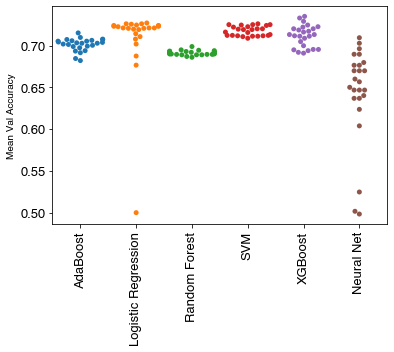

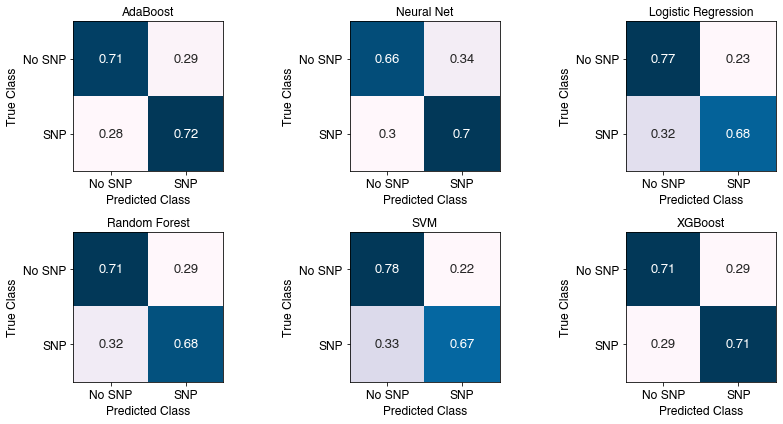

In [22]:
plot_hyperoptimization_performance(hyperopt_result_1_df, hyperopt_models_1)

#### Summary and Next Steps

AdaBoost: performs well, looks like we can give it some more room to grow by increasing n_estimators more. Keep max_depth 1 and learning_rate above 0.2.

Neural Network: a bit hard to figure out; narrow the search space to just 1 or 2 hidden layers, smaller size, and remove regularization to see if we need it

Logistic Regression: C around 0.5 will be good

Random Forest: Try more estimators with low max depth; up to 500

SVM: C around 0.1-0.2 looks good

XGBoost: overfitting, need more regularization; try adding L1 regularization?

### Round 2

In [28]:
hyperopt_models_2 = {
    'AdaBoost': {
        'model': AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1)
        ),
        'param_dists': {
            'n_estimators': np.arange(5, 50),
            'learning_rate': np.arange(0.2, 1, 0.01)
        }
    },
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (1, 2),
        'hidden_layer_size': (16, 64),
        'dropout_rate': (0, 0),
        'l2': (0, 0)
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            penalty='l1',
            solver='saga'
        ),
        'param_dists': {
            'C': np.arange(0.4, 0.6, 0.01)
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(50, 500, 10),
            'max_depth': np.arange(2, 4),
            'min_samples_split': np.arange(2, 6),
            'min_samples_leaf': np.arange(1, 5)
        }
    },
    'SVM': {
        'model': LinearSVC(
            penalty='l1',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'C': np.arange(0.05, 0.25, 0.01)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(5, 50, 2),
            'learning_rate': np.arange(0.05, 0.5, 0.01),
            'reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1]
        },
        'n_iter': 25
    }
}

In [32]:
hyperopt_result_2_df = hyperoptimize(hyperopt_models_2, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_2.csv'))

Loaded cached result!


AdaBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,tn,fn,fp,tp
41,0.731436,0.722772,26.0,0.30,0.720792,0.275248,0.279208,0.724752
35,0.738366,0.723267,33.0,0.31,0.729703,0.283168,0.270297,0.716832
8,0.748515,0.725743,34.0,0.45,0.720792,0.269307,0.279208,0.730693
24,0.728218,0.717822,25.0,0.26,0.714851,0.279208,0.285149,0.720792
47,0.754703,0.727228,47.0,0.30,0.731683,0.277228,0.268317,0.722772
7,0.744678,0.723267,32.0,0.42,0.713861,0.267327,0.286139,0.732673
29,0.751114,0.722277,37.0,0.39,0.726733,0.282178,0.273267,0.717822
13,0.739975,0.719802,27.0,0.45,0.711881,0.272277,0.288119,0.727723
15,0.755446,0.724257,47.0,0.28,0.734653,0.286139,0.265347,0.713861
26,0.748762,0.719307,35.0,0.47,0.711881,0.273267,0.288119,0.726733


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
42,0.809052,0.735974,1.0,63.0,50.0,0.0,0.0,0.728477,0.256579,0.271523,0.743421
24,0.798444,0.726073,2.0,48.0,50.0,0.0,0.0,0.728477,0.276316,0.271523,0.723684
48,0.803395,0.722772,1.0,17.0,54.0,0.0,0.0,0.728477,0.282895,0.271523,0.717105
46,0.809760,0.722772,1.0,40.0,44.0,0.0,0.0,0.715232,0.269737,0.284768,0.730263
14,0.811881,0.729373,2.0,52.0,41.0,0.0,0.0,0.708609,0.250000,0.291391,0.750000
36,0.826025,0.716172,1.0,63.0,19.0,0.0,0.0,0.715232,0.282895,0.284768,0.717105
19,0.817539,0.726073,2.0,37.0,25.0,0.0,0.0,0.754967,0.302632,0.245033,0.697368
49,0.799151,0.719472,1.0,24.0,43.0,0.0,0.0,0.748344,0.309211,0.251656,0.690789
6,0.848656,0.719472,2.0,62.0,49.0,0.0,0.0,0.721854,0.282895,0.278146,0.717105
8,0.857143,0.726073,2.0,33.0,40.0,0.0,0.0,0.715232,0.263158,0.284768,0.736842


Logistic Regression


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
2,0.731683,0.720792,0.42,0.766337,0.324752,0.233663,0.675248
0,0.729703,0.719307,0.40,0.766337,0.327723,0.233663,0.672277
1,0.731312,0.719802,0.41,0.767327,0.327723,0.232673,0.672277
6,0.734777,0.720297,0.46,0.767327,0.326733,0.232673,0.673267
5,0.734158,0.719802,0.45,0.766337,0.326733,0.233663,0.673267
4,0.733540,0.719307,0.44,0.765347,0.326733,0.234653,0.673267
3,0.732797,0.718812,0.43,0.764356,0.326733,0.235644,0.673267
19,0.746658,0.720297,0.59,0.760396,0.319802,0.239604,0.680198
8,0.737500,0.719307,0.48,0.764356,0.325743,0.235644,0.674257
7,0.736757,0.719307,0.47,0.765347,0.326733,0.234653,0.673267


Random Forest


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,tn,fn,fp,tp
14,0.706931,0.699010,100.0,2.0,5.0,1.0,0.701980,0.303960,0.298020,0.696040
47,0.707178,0.697525,410.0,2.0,4.0,3.0,0.699010,0.303960,0.300990,0.696040
29,0.716089,0.698020,320.0,3.0,2.0,1.0,0.697030,0.300990,0.302970,0.699010
23,0.706931,0.696535,190.0,2.0,5.0,4.0,0.700990,0.307921,0.299010,0.692079
28,0.714604,0.697525,160.0,3.0,4.0,3.0,0.696040,0.300990,0.303960,0.699010
30,0.707302,0.694554,420.0,2.0,4.0,2.0,0.695050,0.305941,0.304950,0.694059
25,0.713243,0.696040,200.0,3.0,3.0,4.0,0.696040,0.303960,0.303960,0.696040
33,0.714109,0.696040,360.0,3.0,5.0,3.0,0.696040,0.303960,0.303960,0.696040
21,0.706188,0.693564,80.0,2.0,4.0,2.0,0.693069,0.305941,0.306931,0.694059
41,0.713861,0.696535,150.0,3.0,5.0,1.0,0.698020,0.304950,0.301980,0.695050


SVM


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
4,0.724505,0.720297,0.09,0.774257,0.333663,0.225743,0.666337
7,0.736262,0.721782,0.12,0.774257,0.330693,0.225743,0.669307
6,0.733540,0.720792,0.11,0.774257,0.332673,0.225743,0.667327
3,0.718441,0.715347,0.08,0.769307,0.338614,0.230693,0.661386
2,0.714356,0.712871,0.07,0.768317,0.342574,0.231683,0.657426
16,0.769678,0.726733,0.21,0.773267,0.319802,0.226733,0.680198
5,0.727228,0.717327,0.10,0.774257,0.339604,0.225743,0.660396
1,0.707797,0.710396,0.06,0.764356,0.343564,0.235644,0.656436
17,0.772277,0.724257,0.22,0.767327,0.318812,0.232673,0.681188
11,0.753094,0.722277,0.16,0.775248,0.330693,0.224752,0.669307


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,tn,fn,fp,tp
13,0.909777,0.735644,49.0,0.10,1.0000,0.718812,0.247525,0.281188,0.752475
24,0.865965,0.727723,37.0,0.06,1.0000,0.696040,0.240594,0.303960,0.759406
11,0.919059,0.731188,19.0,0.26,0.0100,0.727723,0.265347,0.272277,0.734653
1,0.858787,0.717822,7.0,0.48,1.0000,0.698020,0.262376,0.301980,0.737624
7,0.909282,0.725743,17.0,0.26,0.1000,0.723762,0.272277,0.276238,0.727723
22,0.889480,0.727228,19.0,0.19,1.0000,0.707921,0.253465,0.292079,0.746535
9,0.855322,0.720792,7.0,0.27,1.0000,0.687129,0.245545,0.312871,0.754455
17,0.904703,0.727723,17.0,0.23,0.0001,0.712871,0.257426,0.287129,0.742574
23,0.857921,0.724257,11.0,0.13,0.0010,0.683168,0.234653,0.316832,0.765347
0,0.887871,0.729703,27.0,0.10,0.0100,0.697030,0.237624,0.302970,0.762376


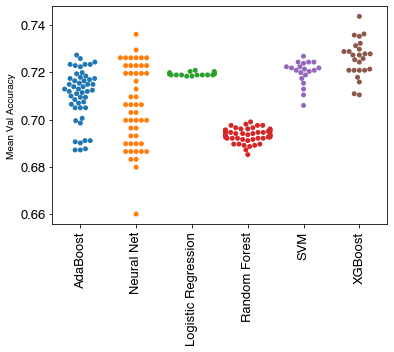

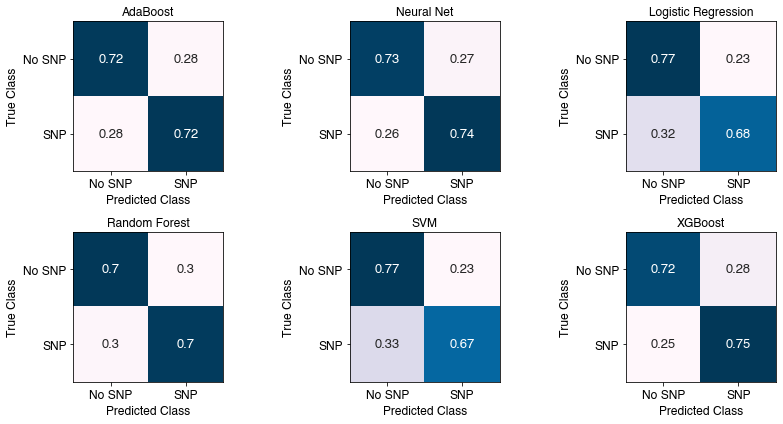

In [33]:
plot_hyperoptimization_performance(hyperopt_result_2_df, hyperopt_models_2)

#### Summary and Next Steps

AdaBoost: yes, increasing estimators worked a bit better, with a touch more overfitting. Let's give the hardest examples some more time and boost that too 100.

Neural Network: Better! A touch of overfitting now, let's add in L2 regularization on the weights

Logistic Regression: Maybe C more around 0.4, try a tight scan there

Random Forest: Let's isolate the effect of more estimators by removing the min_samples params for now

SVM: C around 0.1 is best performance/overfitting balance

XGBoost: overfitting, add back in L2?

### Round 3

In [34]:
hyperopt_models_3 = {
    'AdaBoost': {
        'model': AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1)
        ),
        'param_dists': {
            'n_estimators': np.arange(10, 100),
            'learning_rate': np.arange(0.2, 1, 0.01)
        }
    },
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (1, 2),
        'hidden_layer_size': (16, 64),
        'dropout_rate': (0, 0),
        'l2': (0.0001, 0.1)
    },
    'Logistic Regression': {
        'model': LogisticRegression(
            penalty='l1',
            solver='saga'
        ),
        'param_dists': {
            'C': np.arange(0.35, 0.45, 0.001)
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(50, 500, 10),
            'max_depth': np.arange(2, 5)
        }
    },
    'SVM': {
        'model': LinearSVC(
            penalty='l1',
            dual=False,
            verbose=1
        ),
        'param_dists': {
            'C': np.arange(0.05, 0.15, 0.001)
        }
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(5, 50, 2),
            'learning_rate': np.arange(0.05, 0.5, 0.01),
            'reg_lambda': [0.0001, 0.001, 0.01, 0.1, 1, 10],
            'reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]
        },
        'n_iter': 25
    }
}

In [37]:
hyperopt_result_3_df = hyperoptimize(hyperopt_models_3, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_3.csv'))

Loaded cached result!


AdaBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,tn,fn,fp,tp
37,0.731807,0.721287,34,0.22,0.720792,0.278218,0.279208,0.721782
23,0.735767,0.721782,30,0.31,0.728713,0.285149,0.271287,0.714851
4,0.727723,0.716832,24,0.33,0.711881,0.278218,0.288119,0.721782
9,0.738738,0.718812,28,0.39,0.711881,0.274257,0.288119,0.725743
6,0.748144,0.716832,31,0.62,0.714851,0.281188,0.285149,0.718812
38,0.759530,0.722277,41,0.49,0.729703,0.285149,0.270297,0.714851
10,0.739356,0.714851,34,0.27,0.723762,0.294059,0.276238,0.705941
16,0.752970,0.715842,31,0.69,0.713861,0.282178,0.286139,0.717822
26,0.707054,0.697030,13,0.21,0.699010,0.304950,0.300990,0.695050
32,0.764851,0.728713,53,0.3,0.760396,0.302970,0.239604,0.697030


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
4,0.787129,0.755776,2.0,22.0,36.0,0.0,0.014731,0.748344,0.236842,0.251656,0.763158
7,0.741867,0.739274,2.0,23.0,38.0,0.0,0.023401,0.728477,0.250000,0.271523,0.750000
6,0.748939,0.742574,2.0,23.0,47.0,0.0,0.031110,0.715232,0.230263,0.284768,0.769737
3,0.753182,0.742574,2.0,59.0,20.0,0.0,0.009143,0.715232,0.230263,0.284768,0.769737
24,0.720651,0.732673,1.0,41.0,18.0,0.0,0.084442,0.748344,0.282895,0.251656,0.717105
10,0.741867,0.735974,1.0,30.0,55.0,0.0,0.026323,0.761589,0.289474,0.238411,0.710526
13,0.727016,0.735974,1.0,18.0,33.0,0.0,0.019643,0.761589,0.289474,0.238411,0.710526
43,0.712164,0.726073,2.0,17.0,29.0,0.0,0.098308,0.735099,0.282895,0.264901,0.717105
28,0.698727,0.732673,1.0,21.0,38.0,0.0,0.086024,0.728477,0.263158,0.271523,0.736842
48,0.695898,0.729373,2.0,59.0,36.0,0.0,0.093298,0.728477,0.269737,0.271523,0.730263


Logistic Regression


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
38,0.726485,0.720297,0.369,0.764356,0.323762,0.235644,0.676238
23,0.727351,0.720792,0.372,0.765347,0.323762,0.234653,0.676238
25,0.726733,0.719802,0.364,0.763366,0.323762,0.236634,0.676238
30,0.726733,0.719802,0.368,0.763366,0.323762,0.236634,0.676238
31,0.726856,0.719802,0.367,0.763366,0.323762,0.236634,0.676238
46,0.726238,0.719307,0.362,0.762376,0.323762,0.237624,0.676238
28,0.724876,0.718812,0.359,0.762376,0.324752,0.237624,0.675248
9,0.727104,0.719802,0.374,0.765347,0.325743,0.234653,0.674257
8,0.728960,0.720792,0.395,0.767327,0.325743,0.232673,0.674257
27,0.728960,0.720792,0.396,0.767327,0.325743,0.232673,0.674257


Random Forest


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_max_depth,tn,fn,fp,tp
32,0.706807,0.696535,490,2,0.694059,0.300990,0.305941,0.699010
45,0.705322,0.696040,60,2,0.699010,0.306931,0.300990,0.693069
6,0.705693,0.695545,120,2,0.698020,0.306931,0.301980,0.693069
24,0.726856,0.702970,310,4,0.699010,0.293069,0.300990,0.706931
17,0.714975,0.697525,410,3,0.696040,0.300990,0.303960,0.699010
43,0.706931,0.698515,310,2,0.689109,0.292079,0.310891,0.707921
35,0.725248,0.700990,200,4,0.703960,0.301980,0.296040,0.698020
44,0.705198,0.693564,210,2,0.696040,0.308911,0.303960,0.691089
20,0.709777,0.696040,270,2,0.700990,0.308911,0.299010,0.691089
0,0.714109,0.695545,150,3,0.697030,0.305941,0.302970,0.694059


SVM


,mean_train_accuracy,mean_test_accuracy,param_C,tn,fn,fp,tp
25,0.724505,0.720297,0.09,0.774257,0.333663,0.225743,0.666337
26,0.735396,0.722772,0.115,0.776238,0.330693,0.223762,0.669307
7,0.735767,0.721782,0.119,0.774257,0.330693,0.225743,0.669307
42,0.735272,0.722277,0.116,0.776238,0.331683,0.223762,0.668317
47,0.736139,0.721782,0.12,0.774257,0.330693,0.225743,0.669307
31,0.735644,0.722277,0.117,0.776238,0.331683,0.223762,0.668317
29,0.738119,0.722772,0.124,0.776238,0.330693,0.223762,0.669307
43,0.735644,0.721782,0.118,0.775248,0.331683,0.224752,0.668317
21,0.720297,0.717327,0.085,0.772277,0.337624,0.227723,0.662376
37,0.733663,0.721287,0.109,0.775248,0.332673,0.224752,0.667327


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,param_reg_alpha,tn,fn,fp,tp
23,0.889604,0.735149,17,0.2,0.0001,1,0.713861,0.243564,0.286139,0.756436
7,0.905941,0.729208,15,0.32,0.0001,1,0.718812,0.260396,0.281188,0.739604
19,0.858292,0.721287,7,0.31,0.001,1,0.693069,0.250495,0.306931,0.749505
12,0.872277,0.726733,13,0.15,0.001,0.1,0.696040,0.242574,0.303960,0.757426
24,0.897153,0.735149,23,0.15,0.0001,1,0.702970,0.232673,0.297030,0.767327
1,0.893069,0.727228,49,0.17,10,1,0.705941,0.251485,0.294059,0.748515
10,0.902723,0.724752,39,0.24,10,1,0.709901,0.260396,0.290099,0.739604
11,0.923144,0.729703,23,0.27,1,0.0001,0.715842,0.256436,0.284158,0.743564
15,0.800743,0.699010,47,0.11,0.01,10,0.662376,0.264356,0.337624,0.735644
21,0.862871,0.714851,9,0.21,0.0001,0.1,0.683168,0.253465,0.316832,0.746535


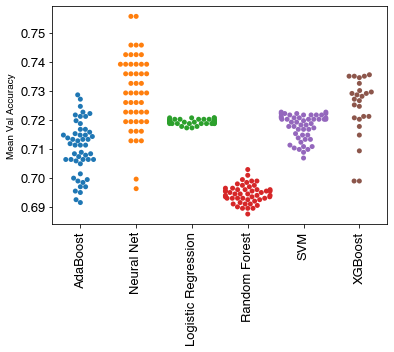

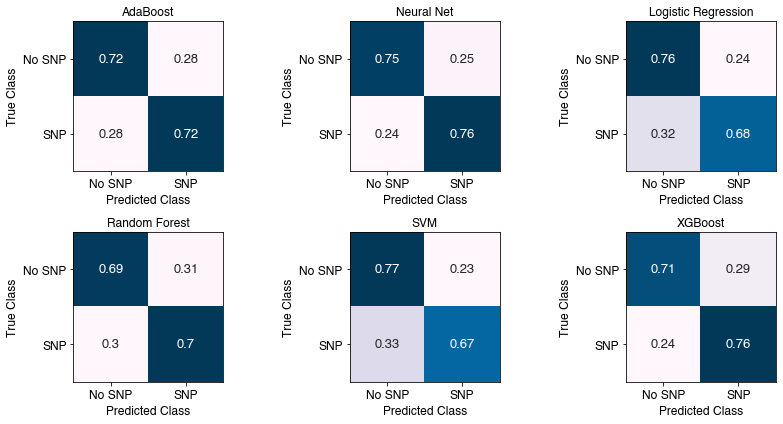

In [36]:
plot_hyperoptimization_performance(hyperopt_result_3_df, hyperopt_models_3)

#### Summary and Next Steps

AdaBoost: seems like around 40 estimators is best to prevent overfitting; let's do one last scan over learning rates.

Neural Network: Much better! Let's try 2 hidden layers and leave L2 right where it is to see if we can boost accuracy further. Not much overfitting right now.

[DONE] Logistic Regression: C=0.37 seems like the best we can do. let's call it.

[DONE] Random Forest: Not really getting any change; let's call it and leave n_estimators=100, max_depth=3

[DONE] SVM: C at 0.1 is best

XGBoost: still a lot of overfitting; let's keep n_estimators small and add very strong regularization parameters; lambda needs to be greater than 1 to do anything more than default

In [44]:
best_models = {
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.37
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False,
        C=0.1
    )
}

### Round 4

In [39]:
hyperopt_models_4 = {
    'AdaBoost': {
        'model': AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=40
        ),
        'param_dists': {
            'learning_rate': np.arange(0.1, 10, 0.01)
        }
    },
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (16, 64),
        'dropout_rate': (0, 0),
        'l2': (0.0001, 0.1)
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(2, 15),
            'learning_rate': np.arange(0.5, 1, 0.01),
            'reg_lambda': [1, 10, 100],
            'reg_alpha': [0.1, 1, 10]
        }
    }
}

In [42]:
hyperopt_result_4_df = hyperoptimize(hyperopt_models_4, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_4.csv'))

Loaded cached result!


AdaBoost


,mean_train_accuracy,mean_test_accuracy,param_learning_rate,tn,fn,fp,tp
4,0.753465,0.723762,0.39,0.721782,0.274257,0.278218,0.725743
37,0.750124,0.721782,0.38,0.708911,0.265347,0.291089,0.734653
41,0.757426,0.722772,0.49,0.735644,0.290099,0.264356,0.709901
10,0.758168,0.700495,1.69,0.704950,0.303960,0.295050,0.696040
13,0.771411,0.706931,0.80,0.694059,0.280198,0.305941,0.719802
1,0.763366,0.709406,0.67,0.747525,0.328713,0.252475,0.671287
22,0.785272,0.701980,1.12,0.731683,0.327723,0.268317,0.672277
36,0.744678,0.681188,1.78,0.703960,0.341584,0.296040,0.658416
2,0.713119,0.678218,1.93,0.728713,0.372277,0.271287,0.627723
28,0.783168,0.698020,1.14,0.746535,0.350495,0.253465,0.649505


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
14,0.733380,0.735974,2.0,44.0,49.0,0.0,0.026589,0.756579,0.284768,0.243421,0.715232
36,0.707214,0.732673,2.0,18.0,20.0,0.0,0.078805,0.730263,0.264901,0.269737,0.735099
17,0.712871,0.726073,2.0,33.0,38.0,0.0,0.043607,0.723684,0.271523,0.276316,0.728477
21,0.716407,0.735974,2.0,55.0,21.0,0.0,0.043809,0.723684,0.251656,0.276316,0.748344
10,0.721358,0.726073,2.0,37.0,33.0,0.0,0.026080,0.703947,0.251656,0.296053,0.748344
13,0.721358,0.726073,2.0,23.0,51.0,0.0,0.052077,0.750000,0.298013,0.250000,0.701987
5,0.748939,0.739274,2.0,40.0,25.0,0.0,0.022832,0.697368,0.218543,0.302632,0.781457
44,0.701556,0.722772,2.0,41.0,26.0,0.0,0.084749,0.736842,0.291391,0.263158,0.708609
4,0.787129,0.732673,2.0,24.0,63.0,0.0,0.012115,0.723684,0.258278,0.276316,0.741722
25,0.715700,0.719472,2.0,22.0,45.0,0.0,0.058555,0.690789,0.251656,0.309211,0.748344


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,param_reg_alpha,tn,fn,fp,tp
20,0.760644,0.718812,3.0,0.58,100.0,0.1,0.680198,0.242574,0.319802,0.757426
12,0.814233,0.712871,4.0,0.76,10.0,0.1,0.703960,0.278218,0.296040,0.721782
44,0.775124,0.705446,8.0,0.99,100.0,10.0,0.684158,0.273267,0.315842,0.726733
46,0.738738,0.694059,2.0,0.72,100.0,10.0,0.662376,0.274257,0.337624,0.725743
8,0.766955,0.707921,5.0,0.62,100.0,1.0,0.664356,0.248515,0.335644,0.751485
34,0.764975,0.707426,2.0,0.80,100.0,1.0,0.660396,0.245545,0.339604,0.754455
11,0.758540,0.703465,7.0,0.78,100.0,10.0,0.659406,0.252475,0.340594,0.747525
47,0.768564,0.703960,9.0,0.73,100.0,10.0,0.665347,0.257426,0.334653,0.742574
14,0.796040,0.705446,12.0,0.55,100.0,1.0,0.678218,0.267327,0.321782,0.732673
17,0.838490,0.711881,4.0,0.58,1.0,1.0,0.699010,0.275248,0.300990,0.724752


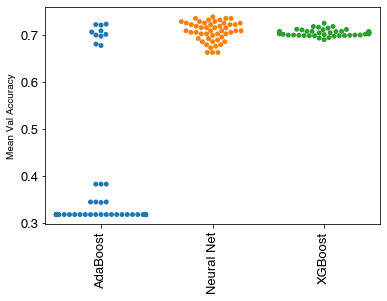

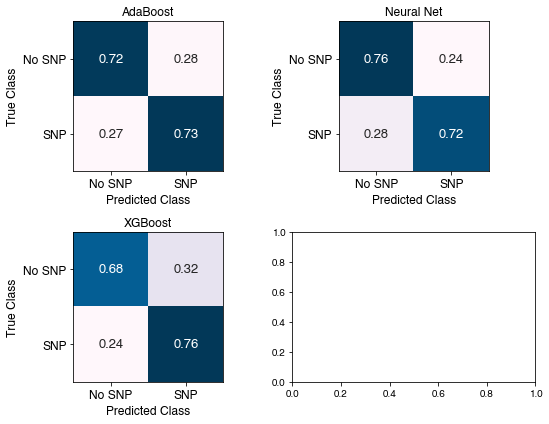

In [43]:
plot_hyperoptimization_performance(hyperopt_result_4_df, hyperopt_models_4)

#### Results Summary and Next Steps

[Done] AdaBoost: Learning rate 0.4, let's call it

Neural Net: Let's try to hone it in a bit more; let there be more layers, and keep L2 right around 0.01-0.1

XGBoost: Let's keep trying to increase regularization until we squash overfitting

In [45]:
best_models['AdaBoost'] = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=40,
    learning_rate=0.4
)

### Round 5

In [46]:
hyperopt_models_5 = {
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (20, 100),
        'dropout_rate': (0, 0),
        'l2': (0.01, 0.1)
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(2, 10),
            'learning_rate': np.arange(0.5, 1, 0.01),
            'reg_lambda': [10, 100, 1000],
            'reg_alpha': [1, 10, 100]
        }
    }
}

In [49]:
hyperopt_result_5_df = hyperoptimize(hyperopt_models_5, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_5.csv'))

Loaded cached result!


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
18,0.715700,0.722772,2.0,98.0,100.0,0.0,0.022964,0.715232,0.269737,0.284768,0.730263
42,0.701556,0.719472,2.0,55.0,92.0,0.0,0.093514,0.708609,0.269737,0.291391,0.730263
47,0.697313,0.712871,2.0,79.0,20.0,0.0,0.078957,0.708609,0.282895,0.291391,0.717105
16,0.727016,0.726073,2.0,26.0,70.0,0.0,0.031890,0.761589,0.309211,0.238411,0.690789
23,0.710750,0.712871,2.0,95.0,43.0,0.0,0.040091,0.695364,0.269737,0.304636,0.730263
44,0.695191,0.712871,2.0,43.0,74.0,0.0,0.092836,0.721854,0.296053,0.278146,0.703947
28,0.713579,0.716172,2.0,63.0,71.0,0.0,0.053024,0.741722,0.309211,0.258278,0.690789
41,0.690948,0.722772,2.0,53.0,85.0,0.0,0.095182,0.708609,0.263158,0.291391,0.736842
46,0.703678,0.716172,2.0,61.0,51.0,0.0,0.083798,0.695364,0.263158,0.304636,0.736842
22,0.729844,0.712871,2.0,25.0,22.0,0.0,0.037844,0.728477,0.302632,0.271523,0.697368


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,param_reg_alpha,tn,fn,fp,tp
8,0.722277,0.702970,5.0,0.65,1000.0,100.0,0.693069,0.287129,0.306931,0.712871
27,0.724134,0.699010,2.0,0.60,100.0,100.0,0.701980,0.303960,0.298020,0.696040
48,0.734158,0.711881,8.0,0.95,1000.0,1.0,0.674257,0.250495,0.325743,0.749505
0,0.733168,0.711881,9.0,0.74,1000.0,10.0,0.672277,0.248515,0.327723,0.751485
41,0.729703,0.704950,8.0,0.91,1000.0,100.0,0.677228,0.267327,0.322772,0.732673
4,0.731188,0.700990,3.0,0.64,1000.0,10.0,0.682178,0.280198,0.317822,0.719802
5,0.733787,0.704455,4.0,0.59,1000.0,10.0,0.679208,0.270297,0.320792,0.729703
31,0.734158,0.714851,9.0,0.77,1000.0,10.0,0.667327,0.237624,0.332673,0.762376
33,0.733787,0.703960,4.0,0.67,1000.0,10.0,0.678218,0.270297,0.321782,0.729703
40,0.728837,0.705446,5.0,0.50,100.0,100.0,0.672277,0.261386,0.327723,0.738614


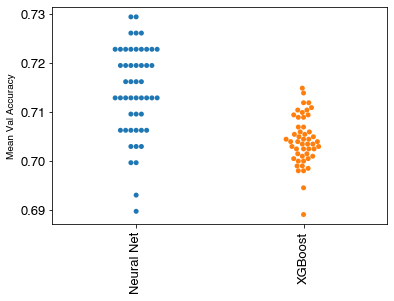

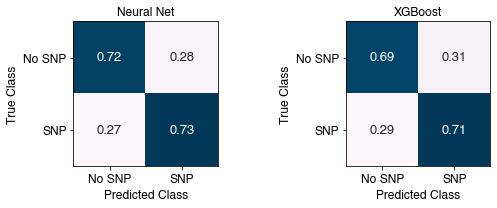

In [50]:
plot_hyperoptimization_performance(hyperopt_result_5_df, hyperopt_models_5)

#### Results Summary and Next Steps

Neural Net: Let's see what happens if we keep layer size between 50-100 and remove regularization; better performance?

XGBoost: We've pretty much wrangled in the overfitting; can we now add estimators to recover performance?

### Round 6

In [51]:
hyperopt_models_6 = {
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (50, 100),
        'dropout_rate': (0, 0),
        'l2': (0, 0)
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(2, 50),
            'learning_rate': np.arange(0.5, 1, 0.01),
            'reg_lambda': [1000, 10000],
            'reg_alpha': [10, 100, 1000]
        }
    }
}

In [54]:
hyperopt_result_6_df = hyperoptimize(hyperopt_models_6, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_6.csv'))

Loaded cached result!


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
48,0.811174,0.729373,2.0,60.0,55.0,0.0,0.0,0.768212,0.309211,0.231788,0.690789
46,0.880481,0.742574,2.0,98.0,64.0,0.0,0.0,0.781457,0.296053,0.218543,0.703947
40,0.914427,0.726073,2.0,64.0,99.0,0.0,0.0,0.748344,0.296053,0.251656,0.703947
39,0.909477,0.716172,2.0,94.0,87.0,0.0,0.0,0.695364,0.263158,0.304636,0.736842
38,0.925743,0.712871,2.0,59.0,78.0,0.0,0.0,0.695364,0.269737,0.304636,0.730263
42,0.930693,0.719472,2.0,76.0,72.0,0.0,0.0,0.748344,0.309211,0.251656,0.690789
36,0.912306,0.716172,2.0,73.0,57.0,0.0,0.0,0.675497,0.243421,0.324503,0.756579
47,0.950495,0.702970,2.0,83.0,87.0,0.0,0.0,0.701987,0.296053,0.298013,0.703947
24,0.922207,0.696370,2.0,85.0,88.0,0.0,0.0,0.708609,0.315789,0.291391,0.684211
43,0.962518,0.702970,2.0,96.0,98.0,0.0,0.0,0.695364,0.289474,0.304636,0.710526


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,param_reg_alpha,tn,fn,fp,tp
21,0.722030,0.700000,30.0,0.63,10000.0,100.0,0.704950,0.304950,0.295050,0.695050
22,0.732302,0.700495,2.0,0.87,1000.0,10.0,0.699010,0.298020,0.300990,0.701980
48,0.723020,0.699505,32.0,0.89,10000.0,100.0,0.692079,0.293069,0.307921,0.706931
28,0.723515,0.699505,31.0,0.83,10000.0,100.0,0.692079,0.293069,0.307921,0.706931
36,0.720050,0.696535,3.0,0.56,1000.0,100.0,0.689109,0.296040,0.310891,0.703960
41,0.731064,0.701485,3.0,0.56,1000.0,10.0,0.685149,0.282178,0.314851,0.717822
16,0.742079,0.712376,17.0,0.87,1000.0,10.0,0.680198,0.255446,0.319802,0.744554
18,0.730817,0.709901,26.0,0.95,1000.0,100.0,0.673267,0.253465,0.326733,0.746535
38,0.739728,0.711881,14.0,0.88,1000.0,10.0,0.677228,0.253465,0.322772,0.746535
24,0.733416,0.710891,14.0,0.64,1000.0,10.0,0.673267,0.251485,0.326733,0.748515


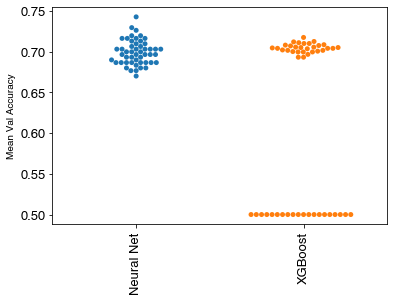

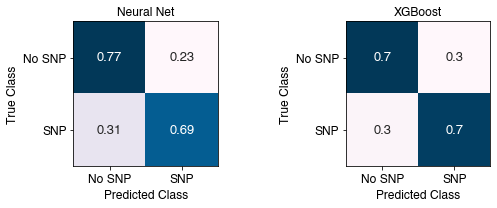

In [55]:
plot_hyperoptimization_performance(hyperopt_result_6_df, hyperopt_models_6)

#### Results Summary and Next Steps

Neural Network: Okay, so we need L2 regularization; add it back, but let the layer sizes get bigger too

XGBoost: let's try one more increasing of n_estimators. And just use one of the regularizations.

### Round 7

In [56]:
hyperopt_models_7 = {
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (50, 150),
        'dropout_rate': (0, 0),
        'l2': (0.001, 0.1)
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(10, 100),
            'learning_rate': np.arange(0.5, 1, 0.01),
            'reg_lambda': [1000, 10000]
        }
    }
}

In [59]:
hyperopt_result_7_df = hyperoptimize(hyperopt_models_7, X_hyperopt, y, n_iter=50, file_path=Path(DATA_PATH, 'hyperopt_7.csv'))

Loaded cached result!


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
33,0.727016,0.722772,2.0,111.0,59.0,0.0,0.045591,0.710526,0.264901,0.289474,0.735099
35,0.730552,0.726073,2.0,103.0,144.0,0.0,0.070054,0.750000,0.298013,0.250000,0.701987
30,0.712871,0.729373,2.0,106.0,110.0,0.0,0.036438,0.750000,0.291391,0.250000,0.708609
8,0.746818,0.719472,2.0,104.0,82.0,0.0,0.011078,0.717105,0.278146,0.282895,0.721854
7,0.784300,0.749175,2.0,143.0,112.0,0.0,0.009507,0.703947,0.205298,0.296053,0.794702
25,0.717822,0.712871,2.0,142.0,120.0,0.0,0.041426,0.743421,0.317881,0.256579,0.682119
10,0.770156,0.726073,2.0,125.0,133.0,0.0,0.016902,0.756579,0.304636,0.243421,0.695364
13,0.751768,0.716172,2.0,75.0,83.0,0.0,0.023850,0.743421,0.311258,0.256579,0.688742
48,0.705799,0.693069,2.0,124.0,65.0,0.0,0.079143,0.703947,0.317881,0.296053,0.682119
18,0.740453,0.699670,2.0,76.0,142.0,0.0,0.032071,0.697368,0.298013,0.302632,0.701987


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,tn,fn,fp,tp
41,0.736510,0.712871,86.0,0.79,10000.0,0.676238,0.250495,0.323762,0.749505
36,0.736262,0.712376,70.0,0.89,10000.0,0.674257,0.249505,0.325743,0.750495
26,0.737624,0.712871,68.0,0.98,10000.0,0.674257,0.248515,0.325743,0.751485
19,0.736510,0.711881,84.0,0.71,10000.0,0.674257,0.250495,0.325743,0.749505
24,0.738243,0.712871,91.0,0.77,10000.0,0.674257,0.248515,0.325743,0.751485
11,0.737376,0.711881,72.0,0.96,10000.0,0.674257,0.250495,0.325743,0.749505
7,0.738119,0.712376,77.0,0.91,10000.0,0.673267,0.248515,0.326733,0.751485
6,0.739604,0.712376,90.0,0.84,10000.0,0.674257,0.249505,0.325743,0.750495
48,0.742698,0.712871,17.0,0.62,1000.0,0.675248,0.249505,0.324752,0.750495
14,0.739480,0.712871,87.0,0.85,10000.0,0.672277,0.246535,0.327723,0.753465


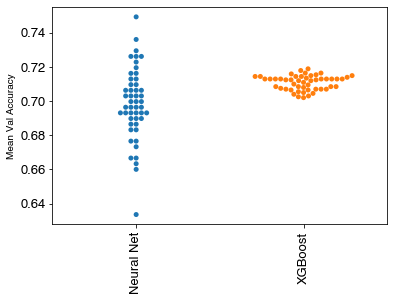

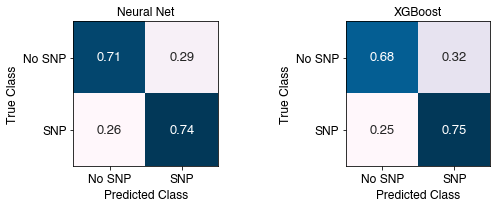

In [60]:
plot_hyperoptimization_performance(hyperopt_result_7_df, hyperopt_models_7)

### Results Summary and Next Steps

Neural Network: We've gotten away from our best performers; let's rein in the layer size.

XGBoost: Let's keep lambda even higher, possibly keep boosting the number of estimators.

### Round 8

In [61]:
hyperopt_models_8 = {
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (16, 64),
        'dropout_rate': (0, 0),
        'l2': (0.001, 0.1)
    },
    'XGBoost': {
        'model': XGBClassifier(
            n_jobs=4
        ),
        'param_dists': {
            'n_estimators': np.arange(50, 150),
            'learning_rate': np.arange(0.5, 1, 0.01),
            'reg_lambda': [10000, 100000]
        }
    }
}

In [65]:
hyperopt_result_8_df = hyperoptimize(hyperopt_models_8, X_hyperopt, y, n_iter=25, file_path=Path(DATA_PATH, 'hyperopt_8.csv'))

Loaded cached result!


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,units_1,rate,l2,tn,fn,fp,tp
2,0.785714,0.739274,2.0,18.0,61.0,0.0,0.018298,0.723684,0.245033,0.276316,0.754967
7,0.733380,0.719472,2.0,57.0,40.0,0.0,0.030731,0.750000,0.311258,0.250000,0.688742
17,0.702263,0.702970,2.0,37.0,38.0,0.0,0.066960,0.723684,0.317881,0.276316,0.682119
12,0.714993,0.689769,2.0,29.0,42.0,0.0,0.066687,0.690789,0.311258,0.309211,0.688742
6,0.732673,0.716172,2.0,24.0,48.0,0.0,0.023797,0.671053,0.238411,0.328947,0.761589
19,0.706506,0.699670,2.0,41.0,26.0,0.0,0.069418,0.730263,0.331126,0.269737,0.668874
0,0.786421,0.729373,2.0,52.0,29.0,0.0,0.003617,0.684211,0.225166,0.315789,0.774834
5,0.741160,0.722772,2.0,41.0,48.0,0.0,0.035856,0.789474,0.344371,0.210526,0.655629
14,0.722065,0.696370,2.0,23.0,60.0,0.0,0.067775,0.664474,0.271523,0.335526,0.728477
8,0.714286,0.702970,2.0,54.0,59.0,0.0,0.054424,0.651316,0.245033,0.348684,0.754967


XGBoost


,mean_train_accuracy,mean_test_accuracy,param_n_estimators,param_learning_rate,param_reg_lambda,tn,fn,fp,tp
24,0.735891,0.711386,77.0,0.67,10000.0,0.675248,0.252475,0.324752,0.747525
12,0.739109,0.710891,98.0,0.77,10000.0,0.673267,0.251485,0.326733,0.748515
21,0.737129,0.711386,109.0,0.59,10000.0,0.671287,0.248515,0.328713,0.751485
8,0.735767,0.710396,61.0,0.92,10000.0,0.670297,0.249505,0.329703,0.750495
3,0.741337,0.711386,123.0,0.66,10000.0,0.672277,0.249505,0.327723,0.750495
13,0.740842,0.710891,88.0,0.90,10000.0,0.671287,0.249505,0.328713,0.750495
0,0.740099,0.710396,112.0,0.71,10000.0,0.671287,0.250495,0.328713,0.749505
18,0.734282,0.707426,86.0,0.51,10000.0,0.667327,0.252475,0.332673,0.747525
11,0.742450,0.709901,140.0,0.65,10000.0,0.669307,0.249505,0.330693,0.750495
22,0.741584,0.708911,121.0,0.71,10000.0,0.669307,0.251485,0.330693,0.748515


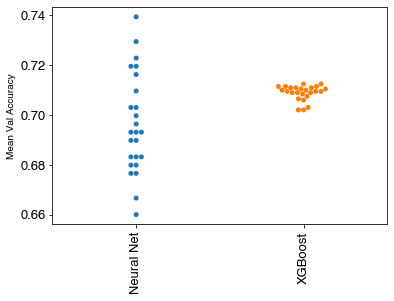

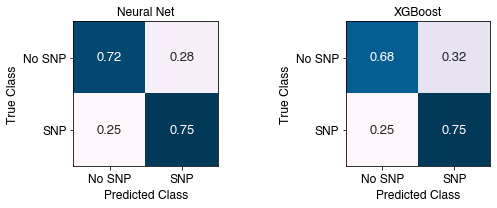

In [66]:
plot_hyperoptimization_performance(hyperopt_result_8_df, hyperopt_models_8)

#### Results Summary and Next Steps

Neural Net: Okay, a bit more performance but a bit more overfitting; let's bump L2 just a tad overall

[DONE] XGBoost: reined in the overfitting finally, not great performance but likely won't get better; leave lambda at 10000, 75 estimators and 0.7 as learning rate seems fine.

In [67]:
best_models['XGBoost'] = XGBClassifier(
    n_estimators=75,
    learning_rate=0.7,
    reg_lambda=10000,
    n_jobs=4
)

### Round 9

In [110]:
hyperopt_models_9 = {
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'n_hidden_layers': (1, 1),
        'hidden_layer_size': (16, 16),
        'dropout_rate': (0, 0),
        'l2': (0.01, 0.02)
    }
}

In [111]:
hyperopt_result_9_df = hyperoptimize(hyperopt_models_9, X_hyperopt, y, n_iter=25, file_path=Path(DATA_PATH, 'hyperopt_9.csv'))

Neural Net


INFO:tensorflow:Oracle triggered exit
10/10 [==============================] - ETA: 0s - loss: 0.6686 - tp: 14.0000 - fp: 6.0000 - tn: 7.0000 - fn: 5.0000 - accuracy: 0.6562 - auc: 0.726 - 0s 2ms/step - loss: 0.6750 - tp: 113.0000 - fp: 61.0000 - tn: 90.0000 - fn: 39.0000 - accuracy: 0.6700 - auc: 0.7350


Neural Net


,mean_train_accuracy,mean_test_accuracy,n_hidden_layers,units_0,rate,l2,tn,fn,fp,tp
18,0.740453,0.699670,1.0,16.0,0.0,0.018995,0.721854,0.322368,0.278146,0.677632
0,0.800566,0.719472,1.0,16.0,0.0,0.010419,0.748344,0.309211,0.251656,0.690789
15,0.743281,0.686469,1.0,16.0,0.0,0.017285,0.682119,0.309211,0.317881,0.690789
22,0.727016,0.679868,1.0,16.0,0.0,0.016876,0.682119,0.322368,0.317881,0.677632
12,0.729844,0.693069,1.0,16.0,0.0,0.013723,0.662252,0.276316,0.337748,0.723684
10,0.748939,0.686469,1.0,16.0,0.0,0.015279,0.695364,0.322368,0.304636,0.677632
23,0.725601,0.679868,1.0,16.0,0.0,0.019888,0.655629,0.296053,0.344371,0.703947
9,0.739038,0.679868,1.0,16.0,0.0,0.013144,0.695364,0.335526,0.304636,0.664474
19,0.724187,0.676568,1.0,16.0,0.0,0.018543,0.649007,0.296053,0.350993,0.703947
5,0.760255,0.683168,1.0,16.0,0.0,0.015207,0.662252,0.296053,0.337748,0.703947


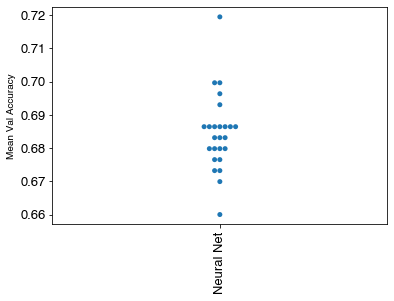

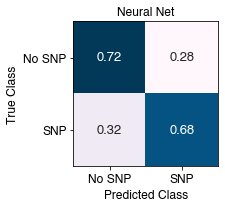

In [113]:
plot_hyperoptimization_performance(hyperopt_result_9_df, hyperopt_models_9)

### Results Summary and Next Steps

A lot of tweaking here, but, besides some flukes, it seems that a simple, 1-layer, 16-neuron network is fine enough.

## Final Model

Let's define the parameters for our best models that we discovered in hyperoptimization

In [13]:
best_models_after_hyperopt = {
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=40,
        learning_rate=0.4
    ),
    'Neural Net': {
        'n_hidden_layers': [1],
        'hidden_layer_sizes': [16],
        'dropout_rates': [0],
        'l2': 0.01
    },
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.37
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False,
        C=0.1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=75,
        learning_rate=0.7,
        reg_lambda=10000,
        n_jobs=4
    )
}

Loaded cached result!


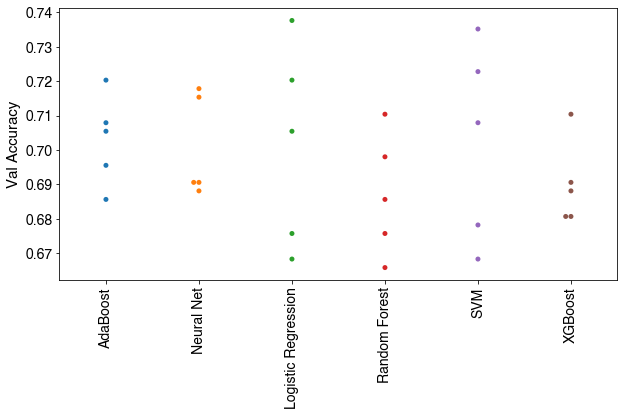

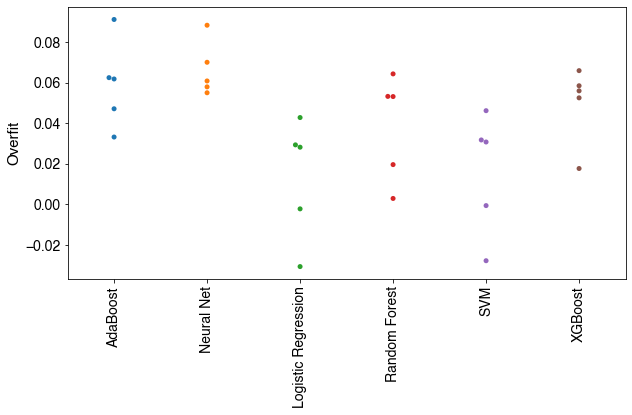

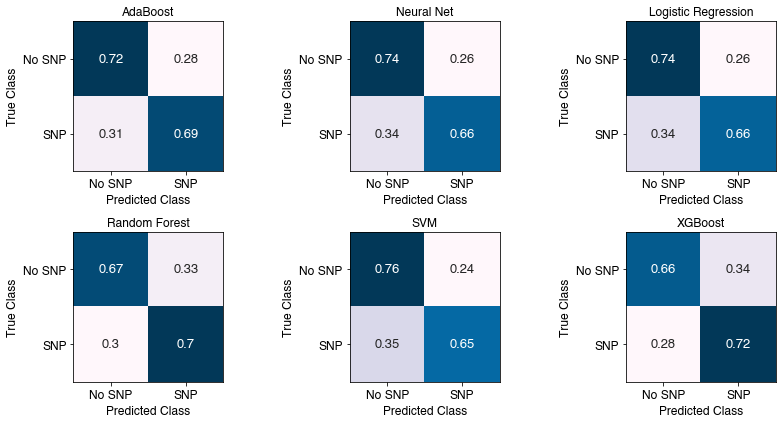

In [14]:
final_hyperopt_df = run_models_and_plot_performance(
    best_models_after_hyperopt,
    {'X_hyperopt': X_hyperopt},
    y,
    file_path=Path(DATA_PATH, 'post_hyperopt_eval.csv'),
    confusion_matrix=True
)

## Test Set Evaluation

### Load Test Data

In [10]:
# load the locus tags and SNP labels for the lockbox
locus_tag_label_lookup_lockbox = pd.read_csv(Path(DATA_PATH, 'test.csv'), index_col=0, squeeze=True)
Y_LOCKBOX_ORIG = locus_tag_label_lookup_lockbox.values

# extract the sub-matrix for each locus tag
GENE_SUB_MATRICES_LOCKBOX = []
for locus_tag in locus_tag_label_lookup_lockbox.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    GENE_SUB_MATRICES_LOCKBOX.append(sub_matrix)
    
X_LOCKBOX_ORIG = np.array([np.asarray(sub_mat.toarray()).sum(axis=1) for sub_mat in GENE_SUB_MATRICES_LOCKBOX])
print(f'{X_LOCKBOX_ORIG.shape}')

# we can define the y we will use now; this ASSUMES that the below helper function will always return 
# a down-sampled X matrix in the appropriate format
neg, pos = np.bincount(Y_LOCKBOX_ORIG)
y_lockbox = np.append(np.zeros(neg), np.ones(neg))

#### Helper Function: Prepare Downsampled Features and Labels with Provided Normalization
def downsample_X_lockbox():
        
    # extract the positive and negative portions of the imbalanced matrix so we can resample the majority class
    neg, pos = np.bincount(Y_LOCKBOX_ORIG)
    
    X_neg = X_LOCKBOX_ORIG[Y_LOCKBOX_ORIG == 0, :]
    X_pos = X_LOCKBOX_ORIG[Y_LOCKBOX_ORIG == 1, :]
    X_pos_downsample = resample(X_pos, replace=True, n_samples=neg)
    X_downsampled = np.vstack((X_neg, X_pos_downsample))
    X_scaled = MinMaxScaler().fit_transform(X_downsampled)
    
    return X_scaled

(838, 1634)


### Evaluate Best Models on Test Data after Re-training

In [11]:
test_models = {
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=40,
        learning_rate=0.4
    ),
    'Neural Net': {
        'n_hidden_layers': [1],
        'hidden_layer_sizes': [16],
        'dropout_rates': [0],
        'l2': 0.01
    },
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga',
        C=0.37
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=3,
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False,
        C=0.1
    ),
    'XGBoost': XGBClassifier(
        n_estimators=75,
        learning_rate=0.7,
        reg_lambda=10000,
        n_jobs=4
    )
}

In [42]:
X_train_final = downsample_X()

In [ ]:
lockbox_eval_df = pd.DataFrame(columns=['model', 'accuracy', 'tn', 'fp', 'fn', 'tp'])

N_LOCKBOX = 5
for model_name, model in test_models.items():

    for i in range(N_LOCKBOX):
        X_train_final = downsample_X()
        X_lockbox = downsample_X_lockbox()

        if model_name == 'Neural Net':
            X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_train_final, y, test_size=0.3, stratify=y)
            nn_model = run_nn_model(model, X_train_nn, y_train_nn, X_val_nn, y_val_nn, return_model=True)
            y_pred = (nn_model.predict(X_lockbox) > 0.5).astype('int32')
        else:
            model.fit(X_train_final, y)
            y_pred = model.predict(X_lockbox)

        accuracy = accuracy_score(y_lockbox, y_pred)
        conf_mat = confusion_matrix(y_lockbox, y_pred, normalize='true')
        tn, fp, fn, tp = conf_mat.flatten()
        lockbox_eval_df = lockbox_eval_df.append({
            'model': model_name,
            'accuracy': accuracy,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'tp': tp
        }, ignore_index=True)

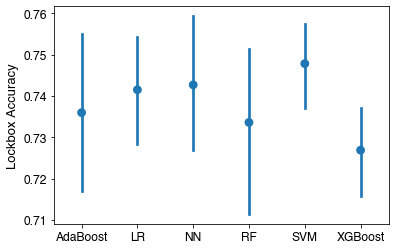

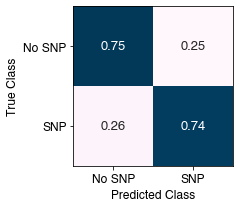

In [54]:
lockbox_eval_df = pd.read_csv(Path(DATA_PATH, 'lockbox_eval.csv'), index_col=0).sort_values(by='model')

_, ax = plt.subplots()
sns.pointplot(x='model', y='accuracy', data=lockbox_eval_df, join=False, ax=ax)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticklabels(['AdaBoost', 'LR', 'NN', 'RF', 'SVM', 'XGBoost'])
ax.set_xlabel('')
ax.set_ylabel('Lockbox Accuracy', fontsize=13)
plt.savefig(Path(FIG_PATH, 'lockbox_eval.svg'))

unique_models = lockbox_eval_df_svm['model'].unique()
num_models = len(unique_models)
if num_models == 1:
    subplot_dims, figsize = (1, 1), (4, 3)
elif num_models == 2:
    subplot_dims, figsize = (1, 2), (8, 3)
elif 3 <= num_models <= 4:
    subplot_dims, figsize = (2, 2), (8, 6)
elif 5 <= num_models <= 6:
    subplot_dims, figsize = (2, 3), (12, 6)
elif 7 <= num_models <= 8:
    subplot_dims, figsize = (2, 4), (12, 6)

_, axs = plt.subplots(*subplot_dims, figsize=figsize)
if num_models == 1:
    axs = [axs]
else:
    axs = axs.flatten()

for model_name, ax in zip(unique_models, axs):

    model_result_df = lockbox_eval_df_svm[lockbox_eval_df_svm['model'] == model_name]
    tn, fp, fn, tp = model_result_df[['tn', 'fp', 'fn', 'tp']].mean(axis=0)

    conf_mat = np.array([np.array([tn, fp]) / (tn + fp), np.array([fn, tp]) / (fn + tp)])

    sns.heatmap(
        conf_mat,
        cmap="PuBu",
        annot=True,
        annot_kws={'fontsize': 13},
        cbar=False,
        square=True,
        xticklabels=['No SNP', 'SNP'],
        yticklabels=['No SNP', 'SNP'],
        ax=ax
    )
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='y', rotation=0)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)

if len(axs) > num_models:
    axs[-1].set_visible(False)

plt.tight_layout()
plt.savefig(Path(FIG_PATH, 'svm_conf_mat.svg'))

### Feature Importance

The SVM model seems to be the best and most balanced; what are its feature importances?

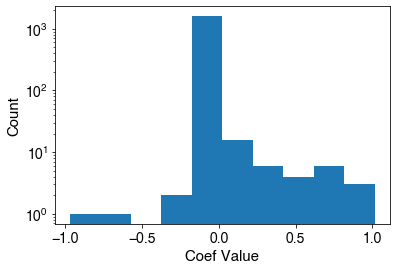

In [56]:
with open(Path(DATA_PATH, 'svm_best.pkl'), 'rb') as readfile:
    svm_best = pickle.load(readfile)
coefs = svm_best.coef_.flatten()
coef_df = pd.DataFrame(data={
    'feature': bitome.matrix_row_labels,
    'coef': coefs,
    'coef_abs': np.abs(coefs)
})

_, ax = plt.subplots()
ax.hist(coef_df['coef'], log=True)
ax.set_xlabel('Coef Value', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.tick_params(axis='both', labelsize=14)
plt.savefig(Path(FIG_PATH, 'svm_coefs.png'))

In [61]:
high_coef_df = coef_df[coef_df['coef_abs'] > 0.5].sort_values(by='coef_abs', ascending=False)
high_coef_df

,feature,coef,coef_abs
346,codon_TAG_(+3),1.013508,1.013508
348,codon_TAG_(-2),0.992283,0.992283
797,sigmulon_Sigma32,-0.967784,0.967784
345,codon_TAG_(+2),0.854806,0.854806
349,codon_TAG_(-3),0.749414,0.749414
7,base_G_(-1),0.702350,0.702350
5,base_T_(-1),0.689146,0.689146
1,base_T_(+1),0.681696,0.681696
347,codon_TAG_(-1),0.680641,0.680641
0,base_A_(+1),0.674788,0.674788


In [78]:
coef_to_print = high_coef_df.copy()
coef_to_print.loc[882, 'feature'] = 'Fis/H-NS/Lrp Regulon'
coef_to_print = coef_to_print[['feature', 'coef']]
coef_to_print['coef'] = np.round(coef_to_print['coef'], decimals=2)
coef_to_print = coef_to_print.set_index('feature').T.squeeze()
coef_to_print.to_csv(Path(FIG_PATH, 'svm_coef_table.csv'))
coef_to_print

feature
codon_TAG_(+3)          1.01
codon_TAG_(-2)          0.99
sigmulon_Sigma32       -0.97
codon_TAG_(+2)          0.85
codon_TAG_(-3)          0.75
base_G_(-1)             0.70
base_T_(-1)             0.69
base_T_(+1)             0.68
codon_TAG_(-1)          0.68
base_A_(+1)             0.67
Fis/H-NS/Lrp Regulon   -0.62
base_A_(-1)             0.61
codon_TAG_(+1)          0.55
Name: coef, dtype: float64

In [81]:
np.bincount(Y_ORIG)

array([1010, 2339])

In [80]:
X_SUM_ORIG.shape

(3349, 1634)

In [64]:
def compare_feature_values(feature_names):
    feat_idxes = [[i for i, lab in enumerate(bitome.matrix_row_labels) if lab == feat_name][0] for feat_name in feature_names]
    feat_label_df = pd.DataFrame(columns=['feature_name', 'feature_value', 'class'])
    for feat_name, feat_idx in zip(feature_names, feat_idxes):
        feat_label_df = feat_label_df.append(pd.DataFrame(data={
            'feature_value': MinMaxScaler().fit_transform(X_SUM_ORIG)[:, feat_idx],
            'feature_name': feat_name if 'regulon' not in feat_name else 'Fis/H-NS/Lrp Regulon',
            'class': ['SNP' if y_entry == 1 else 'No SNP' for y_entry in Y_ORIG]
        }))
    _, ax = plt.subplots()
    sns.pointplot(y='feature_name', x='feature_value', data=feat_label_df, hue='class', dodge=True, join=False)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel('')
    ax.set_xlabel('Feature Value', fontsize=15)
    ax.legend(fontsize=14)
    plt.savefig(Path(FIG_PATH, 'svm_feat_vals.svg'))

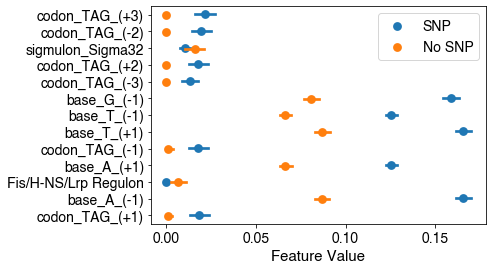

In [65]:
compare_feature_values(list(high_coef_df['feature']))